# Predição de Churn com XGBoost

Este notebook guia você passo a passo:

1. Configuração e dependências
2. Carregamento de dados (CSV ou geração sintética)
3. Exploração rápida
4. Pré-processamento (numérico/categórico)
5. Treino do XGBoost
6. Avaliação (métricas, ROC, matriz de confusão)
7. Explicabilidade (importâncias e SHAP)

Obs.: Ajuste `config/config.yaml` para caminhos e hiperparâmetros.


In [1]:
# Configuração
import os, sys
from pathlib import Path
import yaml

PROJECT_ROOT = Path("..").resolve()
sys.path.insert(0, str(PROJECT_ROOT))
CONFIG_PATH = PROJECT_ROOT / "config" / "config.yaml"

with open(CONFIG_PATH, "r", encoding="utf-8") as f:
    CFG = yaml.safe_load(f)

CFG


{'seed': 42,
 'paths': {'raw_data': 'data/raw/churn.csv',
  'processed_data': 'data/processed/churn_processed.csv',
  'model_dir': 'models',
  'model_file': 'models/xgb_churn.pkl'},
 'model': {'xgboost': {'n_estimators': 300,
   'learning_rate': 0.05,
   'max_depth': 5,
   'subsample': 0.9,
   'colsample_bytree': 0.9,
   'reg_lambda': 1.0,
   'reg_alpha': 0.0,
   'random_state': 42,
   'tree_method': 'auto'}},
 'target': 'churn',
 'test_size': 0.2,
 'positive_class': 1}

In [2]:
# Imports principais
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.data.load import load_raw_csv, generate_synthetic_churn
from src.features.preprocess import build_preprocessing_pipeline
from src.models.train import train_xgboost_classifier
from src.models.evaluate import evaluate_classification, plot_roc_curve, plot_confusion



In [3]:
# Carregamento dos dados (CSV se existir; senão, sintético)
from pathlib import Path
raw_path = PROJECT_ROOT / CFG["paths"]["raw_data"]

if raw_path.exists():
    df = load_raw_csv(raw_path)
else:
    df = generate_synthetic_churn(n_samples=6000, random_state=CFG["seed"])

print(df.shape)
df.head()


(6000, 12)


,num_0,num_1,num_2,num_3,num_4,num_5,num_6,num_7,cat_0,cat_1,cat_2,churn
0,2.463179,-0.177731,-3.097837,-0.725202,2.895848,-0.562587,-0.817984,-2.460159,B,A,B,0
1,2.094274,-2.264422,-2.082028,0.329499,3.714637,-1.260572,-1.466198,-3.265193,A,A,A,0
2,-7.361267,2.463211,3.709226,-1.086643,-3.817241,0.444539,0.906436,-2.893073,C,B,A,0
3,4.579471,-2.253837,-2.722456,-1.556011,3.003207,-2.887207,-1.431753,-1.218797,B,A,C,0
4,2.604669,-0.654109,-1.492855,-0.734632,3.530144,0.096220,-1.680168,-2.052385,A,A,A,0


In [4]:
# Exploração rápida
df.describe(include="all").T.head(20)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
num_0,6000.0,NaN,NaN,NaN,-0.106486,3.168844,-8.406103,-2.554666,-0.313194,2.203517,11.761891
num_1,6000.0,NaN,NaN,NaN,-0.018586,1.829413,-6.571931,-1.284798,0.015372,1.245171,6.13653
num_2,6000.0,NaN,NaN,NaN,0.320547,1.757557,-6.011689,-0.770971,0.508473,1.518202,6.03457
num_3,6000.0,NaN,NaN,NaN,0.008751,1.621336,-5.448052,-1.120434,0.089713,1.162933,5.56998
num_4,6000.0,NaN,NaN,NaN,0.208493,2.517239,-9.348756,-1.615395,0.068562,1.991243,10.738873
num_5,6000.0,NaN,NaN,NaN,-0.710607,1.571916,-6.199312,-1.791696,-0.753212,0.344837,5.483993
num_6,6000.0,NaN,NaN,NaN,-0.999788,1.28379,-6.426719,-1.816934,-0.995561,-0.18742,3.609235
num_7,6000.0,NaN,NaN,NaN,-0.439406,1.679788,-6.264126,-1.615417,-0.477372,0.72428,6.338928
cat_0,6000,3,A,3047,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cat_1,6000,3,A,2963,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Pré-processamento
from src.features.preprocess import build_preprocessing_pipeline

target = CFG["target"]
preprocessor, num_cols, cat_cols = build_preprocessing_pipeline(df, target)

len(num_cols), len(cat_cols), num_cols[:5], cat_cols[:5]


(8,
 3,
 ['num_0', 'num_1', 'num_2', 'num_3', 'num_4'],
 ['cat_0', 'cat_1', 'cat_2'])

In [6]:
# Treino do XGBoost
from xgboost import XGBClassifier
params = CFG["model"]["xgboost"].copy()

result = train_xgboost_classifier(
    df=df,
    target=target,
    preprocessor=preprocessor,
    params=params,
    test_size=CFG["test_size"],
    random_state=CFG["seed"],
)

result.pipeline


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['num_0', 'num_1', 'num_2',
                                                   'num_3', 'num_4', 'num_5',
                                                   'num_6', 'num_7']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [7]:
# Avaliação
from src.models.evaluate import evaluate_classification, plot_roc_curve, plot_confusion

eval_res = evaluate_classification(result.y_test, result.y_pred, result.y_proba)
eval_res.metrics


{'accuracy': 0.945,
 'precision': 0.945619335347432,
 'recall': 0.8670360110803325,
 'f1': 0.9046242774566474,
 'roc_auc': np.float64(0.9784798549915973)}

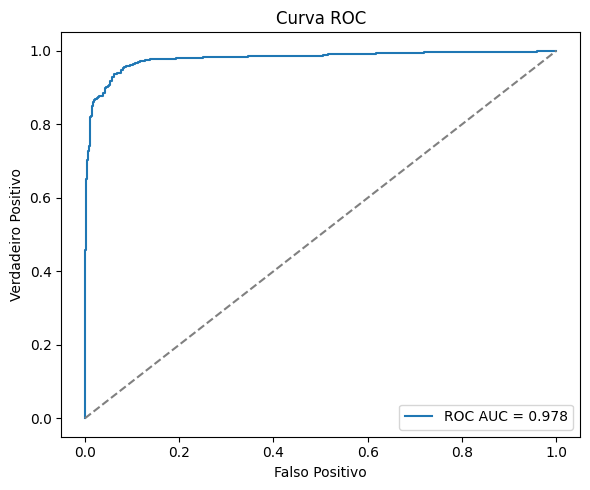

<Figure size 500x400 with 0 Axes>

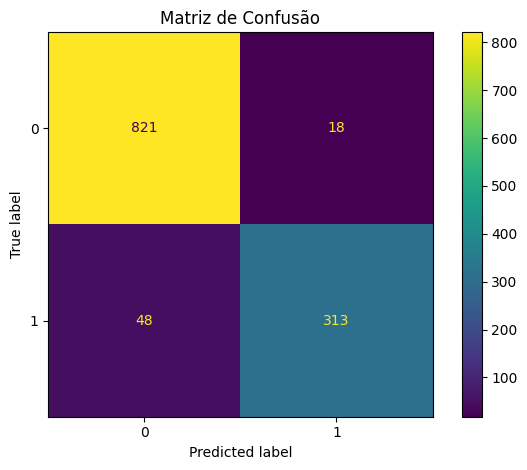

In [8]:
# Curva ROC e Matriz de Confusão
plot_roc_curve(result.y_test, result.y_proba)
plot_confusion(eval_res.confusion_matrix)


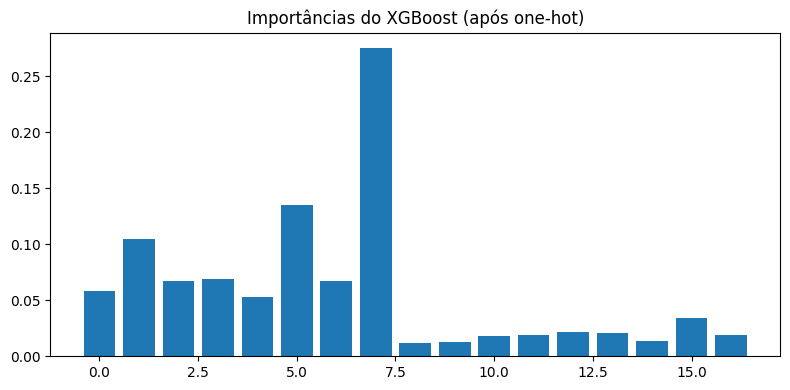

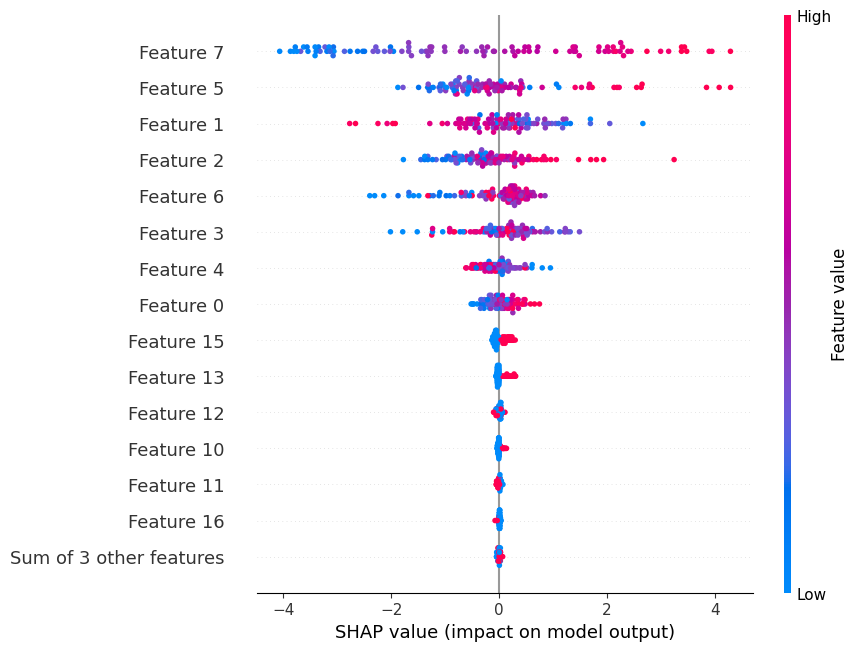

In [9]:
# Importâncias e SHAP (opcional)
import numpy as np
import matplotlib.pyplot as plt
import shap

# Importâncias do modelo
booster = result.pipeline.named_steps["model"]
importances = booster.feature_importances_
plt.figure(figsize=(8,4))
plt.bar(range(len(importances)), importances)
plt.title("Importâncias do XGBoost (após one-hot)")
plt.tight_layout()
plt.show()

# SHAP (amostra por performance)
try:
    explainer = shap.Explainer(booster)
    # cuidado com tamanho; amostre para acelerar
    X_sample = result.pipeline.named_steps["preprocessor"].transform(result.X_test)[:100]
    shap_values = explainer(X_sample)
    shap.plots.beeswarm(shap_values, max_display=15)
except Exception as e:
    print("SHAP indisponível:", e)


In [10]:
# Salvar pipeline treinada
from src.models.save_load import save_pipeline

model_path = PROJECT_ROOT / CFG["paths"]["model_file"]
save_pipeline(result.pipeline, model_path)
model_path


PosixPath('/workspace/models/xgb_churn.pkl')

In [11]:
# (Opcional) Salvar dataset processado
processed_path = PROJECT_ROOT / CFG["paths"]["processed_data"]
processed_path.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(processed_path, index=False)
processed_path


PosixPath('/workspace/data/processed/churn_processed.csv')